<a href="https://colab.research.google.com/github/Gustavoq14/Optimization-Algorithms/blob/main/Benchmarking_DataFitting_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Librerias

In [168]:
!pip install celluloid
import matplotlib.pyplot as plt
import numpy as np
import numba
import pandas as pd
import math
import time
import matplotlib

from scipy.optimize import nnls
from IPython.display import HTML
from celluloid import Camera
from mpl_toolkits.mplot3d import Axes3D
matplotlib.use("agg")

# 2. Funciones

In [124]:
def chi2(datos, funcion, sigma, params):
  if np.isscalar(sigma) and sigma == 0:
        sigma = 1
  else:
        sigma[sigma == 0] = 1
  return np.sum(np.power((datos-funcion)/sigma,2))/(np.size(datos)-(len(params[0])+len(params[1])))

def grad_chi2(datos, funcion, sigma, gradiente, params):
  return np.array([-2*np.sum((datos - funcion)/np.power(sigma,2)*gradiente[i]) for i in range(len(gradiente))])/(np.size(datos)-(len(params[0])+len(params[1])))

def hess_chi2(datos, funcion, sigma, gradiente, hessiana, params):
  return np.array([[2*np.sum((-datos*hessiana[i][j] + gradiente[i]*gradiente[j] + funcion*hessiana[i][j])/np.power(sigma, 2)) for j in range(hessiana.shape[1])] for i in range(hessiana.shape[0])])/(np.size(datos)-(len(params[0])+len(params[1])))

def funcion_1(x, params):
    t1, t3, t5 = params[0][0], params[0][1], params[0][2]
    t2, t4 = params[1][0], params[1][1]
    return t1*np.cos(t2*x)+t3*np.sin(t4*x)+t5

def bases_1(x, params):
    t2, t4 = params[0], params[1]
    return np.array([np.cos(t2*x), np.sin(t4*x), np.ones_like(x)])

def grad_funcion_1(x, params):
    t1, t3 = params[0][0], params[0][1]
    t2, t4 = params[1][0], params[1][1]
    df_dt2 = -t1*x*np.sin(t2*x)
    df_dt4 = t3*x*np.cos(t4*x)
    return np.array([df_dt2, df_dt4])

def hess_funcion_1(x, params):
    t1, t3 = params[0][0], params[0][1]
    t2, t4 = params[1][0], params[1][1]
    df2_dt22 = -t1*np.power(x,2)*np.cos(t2*x)
    df2_dt2dt4 = np.zeros_like(x)
    df2_dt42 = -t3*np.power(x,2)*np.sin(t4*x)
    return np.array([[df2_dt22, df2_dt2dt4], [df2_dt2dt4, df2_dt42]])

def Bzm(chi_1, chi_2, T):
    return np.exp((chi_1-chi_2)/T)

def T_bath(T):
    if T < 10:
        cte = 1.
    else:
        cte = np.log10(T)
    return T/cte

def Temp(k_c, Tmin, Ti):
    return Ti + k_c * (Tmin - Ti)

def leer_resultados(filename):
    with open(filename, 'r') as file:
        header = file.readline().strip().split('\t')
    data = {col: [] for col in header}
    with open(filename, 'r') as file:
        next(file)
        for line in file:
            values = line.strip().split('\t')
            for col, value in zip(header, values):
                if col in ('beta', 'gamma'):
                    data[col].append([float(v) for v in value.split(', ')])
                elif col in ('chi', 'T'):
                    data[col].append(float(value))
                else:
                    data[col].append(int(value))
    df = pd.DataFrame(data)
    return df

def calculate_limits(data_columns):
    all_data = np.concatenate([df_chi[column].values for column in data_columns])
    x_range = (all_data.min(), all_data.max())
    y_max = max([np.histogram(df_chi[column], bins=30)[0].max() for column in data_columns])
    return x_range, y_max

# 3. Métodos de Ajuste de Datos

## 3.1 Mínimos Cuadrados Lineales

In [125]:
def coef_lineal(datos, bases, sigma):
    datos = np.asarray(datos, dtype=np.float64)
    bases = np.asarray(bases, dtype=np.float64)
    sigma = np.asarray(sigma, dtype=np.float64)

    # Si las bases tienen la forma (n_bases, n_data), las transponemos
    if bases.shape[1] == datos.shape[0]:
        bases = bases.T

    sigma[sigma <= 0] = 1.0
    inv_sigma = 1.0 / sigma
    A = bases * inv_sigma[:, np.newaxis]
    b = datos * inv_sigma

    x, *_ = np.linalg.lstsq(A, b, rcond=None)
    return x

## 3.2 Gradiente Descendiente

In [126]:
def mc_gd(x, datos, funcion, sigma, bases, gradiente, params_nl, imax = 1000, kmax = 1000, eta = 0.01, tol = 1e-5, filename = 'mc_gd'):
  results = []
  chi = []
  c = 0
  for i in range(imax):
    gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 = np.dot(beta_0, B_0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)

    k = 0
    s = 0
    gamma_k = gamma_0
    beta_k = beta_0
    chi.append(chi_opt)
    dif = 1

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")
    while k < kmax and dif > tol:
      grad = grad_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      gamma_k -= eta * grad / np.linalg.norm(grad)
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      f_k = np.dot(beta_k, B_k)
      chi_nue = chi2(datos, f_k, sigma, [beta_k, gamma_k])
      if chi_nue < chi_opt:
        theta_opt = (beta_k.copy(), gamma_k.copy())
        chi_opt = chi_nue
        chi.append(chi_opt)
        s += 1
        dif = abs(chi[s]-chi[s-1])
      beta_k_str = ", ".join(map(str, beta_k.tolist()))
      gamma_k_str = ", ".join(map(str, gamma_k.tolist()))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")
      k += 1
  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\n")
    file.writelines(results)

## 3.2 Newton-Rapshon

In [127]:
def mc_nr(x, datos, funcion, sigma, bases, gradiente, hessiana, params_nl, imax = 1000, kmax = 1000, tol = 1e-5, filename = 'mc_nr'):
  results = []
  chi = []
  for i in range(imax):
    gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 =np.dot(beta_0, B_0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)

    k = 0
    s = 0
    gamma_k = gamma_0
    beta_k = beta_0
    chi.append(chi_opt)
    dif = 1

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")
    while k < kmax and dif > tol:
      grad = grad_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      H = hess_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), hessiana(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      gamma_k -= np.linalg.solve(H, grad)
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      f_k = np.dot(beta_k, B_k)
      chi_nue = chi2(datos, f_k, sigma, [beta_k, gamma_k])
      if chi_nue < chi_opt:
        theta_opt = (beta_k.copy(), gamma_k.copy())
        chi_opt = chi_nue
        chi.append(chi_opt)
        s += 1
        dif = abs(chi[s] - chi[s-1])
      beta_k_str = ", ".join(map(str, beta_k.tolist()))
      gamma_k_str = ", ".join(map(str, gamma_k.tolist()))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")
      k += 1

  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\n")
    file.writelines(results)

## 3.4 Levenberg Marquart

In [128]:
def mc_lm(x, datos, funcion, sigma, bases, gradiente, hessiana, params_nl, imax=1000, kmax=1000, l=1.0, tol=1e-5, filename='mc_lm'):
    """
    Método de Levenberg–Marquardt Monte Carlo para ajuste mixto lineal/no lineal,
    con criterio de parada y control de lambda mejorados.
    """
    results = []
    chi = []

    for i in range(imax):
        # --- Inicialización aleatoria de parámetros no lineales ---
        gamma = np.array([np.random.uniform(p[0], p[1]) for p in params_nl])
        B = bases(x, gamma)
        beta = coef_lineal(datos, B, sigma)

        f = np.dot(beta, B)
        chi_opt = chi2(datos, f, sigma, [beta, gamma])
        chi_iter = [chi_opt]
        theta_opt = (beta.copy(), gamma.copy())

        # Logging inicial
        beta_str = ", ".join(map(str, beta))
        gamma_str = ", ".join(map(str, gamma))
        results.append(f"{i}\t{0}\t{beta_str}\t{gamma_str}\t{chi_opt}\n")

        for k in range(kmax):
            # --- Gradiente y Hessiana ---
            grad = grad_chi2(datos, funcion(x, [beta, gamma]), sigma, gradiente(x, [beta, gamma]), [beta, gamma])
            H = hess_chi2(datos, funcion(x, [beta, gamma]), sigma, gradiente(x, [beta, gamma]), hessiana(x, [beta, gamma]), [beta, gamma])

            # Paso LM
            I = l * np.eye(H.shape[0])
            try:
                delta = np.linalg.solve(H + I, grad)
            except np.linalg.LinAlgError:
                break  # matriz singular → aborta este intento

            gamma_new = gamma - delta

            # --- Recalcular modelo ---
            B_new = bases(x, gamma_new)
            beta_new = coef_lineal(datos, B_new, sigma)
            f_new = np.dot(beta_new, B_new)
            chi_new = chi2(datos, f_new, sigma, [beta_new, gamma_new])

            # --- Criterio de mejora ---
            if chi_new < chi_iter[-1]:
                gamma = gamma_new
                beta = beta_new
                chi_iter.append(chi_new)
                theta_opt = (beta.copy(), gamma.copy())
                chi_opt = chi_new
                l *= 0.5   # ↓ Disminuye lambda (mayor paso)
            else:
                l *= 2.0   # ↑ Aumenta lambda (menor paso)

            # --- Criterios de parada ---
            if np.linalg.norm(delta) < tol:
                break

            # Limitar rango de lambda
            l = min(max(l, 1e-6), 1e4)

            # Logging
            beta_str = ", ".join(map(str, beta.tolist()))
            gamma_str = ", ".join(map(str, gamma.tolist()))
            results.append(f"{i}\t{k}\t{beta_str}\t{gamma_str}\t{chi_new}\n")

        # Guardar el mejor chi² de este ciclo Monte Carlo
        chi.append(chi_opt)

    # --- Escritura de resultados ---
    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\n")
        file.writelines(results)

    return chi

## 3.5 Monte Carlo-Aceptación y Rechazo

In [129]:
def mc_ar(x, datos, sigma, bases, params_nl, imax = 1000, kmax = 1000, filename='mc_ar'):
  results = []
  for i in range(imax):
    gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 = np.dot(beta_0, B_0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")
    for k in range(0, kmax):
      gamma_k = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      f_k = np.dot(beta_k, B_k)
      theta_k = (beta_k, gamma_k)
      theta_bus = theta_k
      chi_nue = chi2(datos, f_k, sigma, theta_k)
      if chi_nue < chi_opt:
        theta_opt = theta_k
        chi_opt = chi_nue
      beta_k_str = ", ".join(map(str, theta_k[0]))
      gamma_k_str = ", ".join(map(str, theta_k[1]))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")

  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\n")
    file.writelines(results)

## 3.6 Simulated-Annealing

In [130]:
def mc_sa(x, datos, sigma, bases, params_nl, imax=1000, t0 = 1000, kmax=1000, alpha = 0.99, filename="mc_sa"):
    results = []
    for i in range(imax):
        gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)

        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi2(datos, f_0, sigma, theta_0)
        T = t0

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")

        for k in range(kmax):
            gamma_k = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            theta_bus = theta_k
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            if chi_nue < chi_opt:
                chi_opt = chi_nue
                theta_opt = theta_k
            else:
                if np.random.uniform(0, 1) < Bzm(chi_nue, chi_opt, T):
                    chi_opt = chi_nue
                    theta_opt = theta_k


            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")
            T *= alpha
    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)

## 3.7 Self-Cooling Simulated-Annealing

In [131]:
def mc_scsa(x, datos, sigma, bases, params_nl, k_c= None, imax=1000, kmax=1000, filename='mc_scsa'):
    if k_c is None:
        k_c = 5/kmax

    results = []
    var = [(params_nl[j][1] - params_nl[j][0])*0.5 for j in range(len(params_nl))]

    chi_min_global = np.inf
    theta_min_global = None

    for i in range(imax):

        # inicio del ciclo i
        inicio_i = time.time()

        gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)

        # Estado actual de la cadena
        theta_actual = theta_0
        chi_actual = chi2(datos, f_0, sigma, theta_0)

        chi_min_cadena = chi_actual

        # Actualizar mínimo global
        if chi_min_cadena < chi_min_global:
            chi_min_global = chi_actual
            theta_min_global = theta_actual

        # Temperatura inicial
        T_ext = T_bath(chi_min_cadena)
        T = T_ext*1.5

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_actual}\t{T}\n")

        for k in range(kmax):

            inicio_k = time.time()  # inicio del ciclo k

            gamma_k = np.array([np.random.normal(theta_actual[1][j], var[j])
                                for j in range(len(var))])
            while not np.all([limite[0] <= valor <= limite[1]
                              for valor, limite in zip(gamma_k, params_nl)]):
                gamma_k = np.array([np.random.normal(theta_actual[1][j], var[j])
                                    for j in range(len(var))])

            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)

            chi_k = chi2(datos, f_k, sigma, theta_k)
            # Criterio de aceptación
            if chi_k < chi_actual:
                # Siempre aceptar si mejora
                chi_actual = chi_k
                theta_actual = theta_k

                # Actualizar mínimo de la cadena
                if chi_k < chi_min_cadena:
                    chi_min_cadena = chi_k
                    T_ext = T_bath(chi_min_cadena)
                    # Actualizar mínimo global
                    if chi_k < chi_min_global:
                        chi_min_global = chi_k
                        theta_min_global = theta_k

            else:
                if np.random.uniform(0, 1) < Bzm(chi_k, chi_actual, T):
                    chi_actual = chi_k
                    theta_actual = theta_k

            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_k}\t{T}\n")

            T = Temp(k_c, T_ext, T)

    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)

## 3.8 Self-Cooling Simulated-Annealing  Variable Variance

In [132]:
def mc_scsav(x, datos, sigma, bases, params_nl, k_c=0.1, imax=1000, kmax=1000, std_number=3, n=5, filename='mc_scsav'):
    results = []
    initial_var = [(params_nl[j][1] - params_nl[j][0]) * 0.1 for j in range(len(params_nl))]
    accepted_solutions = np.zeros((std_number, len(params_nl)))
    acceptance_counter = 0

    for i in range(imax):
        gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)
        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi_opt

        # Temperatura inicial como en mc_scsa
        T_ext = T_bath(chi_opt)
        T = T_ext * 1.5
        var = initial_var.copy()

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t0\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")

        for k in range(kmax):
            gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])
            while not np.all([limite[0] <= valor <= limite[1] for valor, limite in zip(gamma_k, params_nl)]):
                gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])

            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            # Criterio de aceptación
            if chi_nue < chi_opt:
                chi_opt = chi_nue
                theta_opt = theta_k
                T_ext = T_bath(chi_opt)  # actualizar T_ext como en mc_scsa
                accepted_solutions[acceptance_counter % std_number] = gamma_k
                acceptance_counter += 1
            else:
                if np.random.uniform(0, 1) < Bzm(chi_nue, chi_opt, T):
                    chi_opt = chi_nue
                    theta_opt = theta_k
                    accepted_solutions[acceptance_counter % std_number] = gamma_k
                    acceptance_counter += 1

            if acceptance_counter >= std_number:
                var = np.std(accepted_solutions, axis=0) * n  # ajuste de varianza adaptativa

            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k+1}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")

            # Actualización de temperatura paso a paso
            T = Temp(k_c, T_ext, T)

    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)

# 4. Datos de prueba.

Los datos utilizados para testear los distintos métodos son simulados a partir de un modelo seleccionado según la ecuación.

$$y(x)=\theta_1\cos(\theta_2x)+\theta_3\sin(\theta_4x)+\theta_5$$

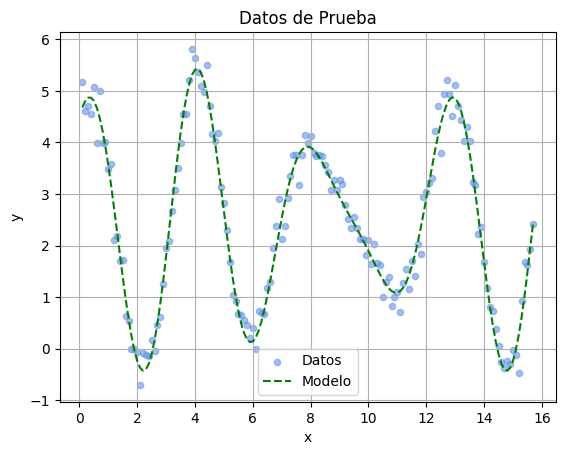

In [133]:
np.random.seed(1)
params_funcion1 = ([2, 1, 2.5], [1.5, 2])
x_funcion1 = np.arange(0.1, 5*np.pi, 0.1)
y_funcion1 = funcion_1(x_funcion1, params_funcion1)
datos_funcion1 = np.random.normal(y_funcion1, 0.3)
sigma_funcion1 = y_funcion1-datos_funcion1
chi_funcion1 = chi2(datos_funcion1, y_funcion1, sigma_funcion1, params_funcion1)

fig = plt.figure()

plt.scatter(x_funcion1, datos_funcion1, s = 20, alpha = 0.6, color = 'cornflowerblue', label = 'Datos')
plt.plot(x_funcion1, y_funcion1, '--', color = 'green', label ='Modelo')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Datos de Prueba')
plt.grid()
plt.legend()

plt.show()

In [134]:
sigma_funcion1

array([-0.48730361,  0.18352692,  0.15845153,  0.32189059, -0.25962229,
        0.69046161, -0.52344353,  0.22836207, -0.09571173,  0.07481111,
       -0.43863238,  0.61804221,  0.09672516,  0.11521631, -0.34013083,
        0.32996738,  0.05172846,  0.26335753, -0.01266412, -0.17484456,
        0.33018575, -0.34341711, -0.27047722, -0.1507483 , -0.27025678,
        0.20511836,  0.03686707,  0.28073083,  0.08036642, -0.15910664,
        0.20749823,  0.11902606,  0.20615181,  0.25356169,  0.20137384,
        0.00379938,  0.3351931 , -0.07032471, -0.49794065, -0.22261325,
        0.05755067,  0.26628869,  0.22414749, -0.50773638, -0.01524233,
        0.19109869, -0.05727465, -0.63007654, -0.03604769, -0.18516093,
       -0.0900511 ,  0.10567495,  0.34275546,  0.10480282,  0.06266827,
       -0.17598696, -0.25169502, -0.27933062, -0.0856762 , -0.26554235,
        0.22631938, -0.37586045, -0.15387895,  0.08942785, -0.14655544,
        0.02267151, -0.33948882, -0.45594504, -0.65567262,  0.41

# 8. Testeo de Métodos

Todos los métodos fueron testeados con 1000 reinicios

In [135]:
tiempo = []
params_nl_funcion1 = [(0.0, 3.0), (0.0, 5.0)]

In [136]:
inicio = time.time()
mc_gd(x_funcion1, datos_funcion1, funcion_1, sigma_funcion1, bases_1, grad_funcion_1, params_nl_funcion1, eta = 0.001)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio: .4}s')

Tiempo de ejecución:  227.9s


In [137]:
inicio = time.time()
mc_nr(x_funcion1, datos_funcion1, funcion_1, sigma_funcion1, bases_1, grad_funcion_1, hess_funcion_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución {fin-inicio:.4}s')

Tiempo de ejecución 320.4s


In [138]:
inicio = time.time()
mc_lm(x_funcion1, datos_funcion1, funcion_1, sigma_funcion1, bases_1, grad_funcion_1, hess_funcion_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio:.4}s')

Tiempo de ejecución: 63.81s


In [139]:
inicio = time.time()
mc_ar(x_funcion1, datos_funcion1, sigma_funcion1, bases_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución {fin-inicio: .4}s')

Tiempo de ejecución  145.2s


In [140]:
inicio = time.time()
mc_sa(x_funcion1, datos_funcion1, sigma_funcion1, bases_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio: .4}s')

/tmp/ipython-input-3956923734.py:39: RuntimeWarning: overflow encountered in exp
  return np.exp((chi_1-chi_2)/T)


Tiempo de ejecución:  153.2s


In [141]:
inicio = time.time()
mc_scsa(x_funcion1, datos_funcion1, sigma_funcion1, bases_1, params_nl_funcion1)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio: .4}s')

Tiempo de ejecución:  201.8s


In [142]:
inicio = time.time()
mc_scsav(x_funcion1, datos_funcion1, sigma_funcion1, bases_1, params_nl_funcion1, std_number = 5)
fin = time.time()
tiempo.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio: .4}s')

Tiempo de ejecución:  384.0s


In [143]:
x = x_funcion1
y = y_funcion1
datos = datos_funcion1

archivos = ['mc_ar', 'mc_sa','mc_scsa', 'mc_scsav', 'mc_gd', 'mc_nr', 'mc_lm']
p_l = []
p_nl = []
ajustes = []
chi = []

for name in archivos:
  df = leer_resultados(name)
  df_n = df[df['i'] == df['i'].iloc[df['chi'].idxmin()]]
  df_n = df_n[df_n['k'] <= df['k'].iloc[df['chi'].idxmin()]]
  ajustes.append(funcion_1(x, [df_n['beta'].values[-1], df_n['gamma'].values[-1]]))
  chi.append(df_n['chi'].values[-1])
  p_l.append(df_n['beta'].values[-1])
  p_nl.append(df_n['gamma'].values[-1])

resultados_funcion1 = pd.DataFrame({
    'Método': archivos,
    'Tiempo de ejecución': tiempo,
    'Chi2': chi,
    'P_L': p_l,
    'P_NL': p_nl
})

resultados_funcion1

,Método,Tiempo de ejecución,Chi2,P_L,P_NL
0,mc_ar,227.853631,0.374316,"[2.0283944089316344, 1.0108781261066664, 2.465...","[1.5014531557608428, 1.9975519991587076]"
1,mc_sa,320.362025,0.400633,"[2.0305052120708313, 1.0109519732783907, 2.465...","[1.5015971997894213, 1.9967156224119247]"
2,mc_scsa,63.807266,0.352036,"[2.0253588454232148, 1.0080891478427185, 2.469...","[1.5007444653054645, 1.9994253978096634]"
3,mc_scsav,145.185979,0.358899,"[2.0202215988010948, 1.0112219228564414, 2.465...","[1.5009691088349704, 2.00066068855235]"
4,mc_gd,153.182088,0.349379,"[2.0236582663303984, 1.010699582430565, 2.4659...","[1.5011105278867922, 1.9994429209026907]"
5,mc_nr,201.837894,0.349364,"[2.02357732599374, 1.010637132879764, 2.466067...","[1.5010934671067018, 1.9994902119430638]"
6,mc_lm,384.022627,0.349365,"[2.0236035553956104, 1.0106108518604109, 2.466...","[1.5010903858866207, 1.9994864976553728]"


# Resultados

Para evaluar el rendimiento de los distintos métodos para el ajuste de datos, se seleccionaron cuatro métricas; tiempo de ejecución (wall time), normalizado por el método más lento, $\chi^2$(bondad del ajuste); NDPEV (Norma de la Diferencia entre Parámetros Estimados y Verdaderos), definida como

$$NDEV=\Vert\theta^{*}-\theta_{V}\Vert$$

Donde $\theta^*\in\mathbb{R}^M$, tal que

$$\chi^2(\theta^*)=\underset{0\leq k\leq n}{\text{min}}\chi^2(\theta^k)$$

y NDMEV (Norma de la Diferencia entre la Media de los Parámetros Estimados y los Parámetros Verdaderos), definida como

$$NDMEV=\sum_{i=0}^{k}\frac{\Vert\theta^{*}_{i}-\theta_{V}\Vert}{k}$$

donde $k$ es la cantidad de reinicios del algoritmo.

Teniendo en cuenta el valor de $\chi^2$ y la norma de los parametros del modelo con el cual se generaron los datos son

In [146]:
P_f1 = np.concatenate(params_funcion1)
print(f'Valor del chi cuadrado del modelo: {chi_funcion1:.4}\nNorma de los parametros del modelo: {np.linalg.norm(P_f1):.4}')

Valor del chi cuadrado del modelo: 1.033
Norma de los parametros del modelo: 4.183


In [148]:
resultados_f1 = resultados_funcion1.copy()

resultados_f1['D_P'] = resultados_f1.apply(lambda row: np.array(row['P_L'] + row['P_NL']) - P_f1, axis=1)
resultados_f1['NDEV'] = resultados_f1['D_P'].apply(np.linalg.norm)
resultados_f1 = resultados_f1.drop(['P_L', 'P_NL', 'D_P'], axis=1)
resultados_f1['Tiempo de ejecución'] = resultados_f1['Tiempo de ejecución']/resultados_f1['Tiempo de ejecución'].max()

NDM_P = []
archivos = ['mc_ar', 'mc_sa','mc_scsa', 'mc_scsav', 'mc_gd', 'mc_nr', 'mc_lm']
for name in archivos:
  df = leer_resultados(name)
  resul = df.copy()

  resul['D_P'] = resul.apply(lambda row: np.array(row['beta'] + row['gamma']) - P_f1, axis=1)
  resul_mc_ar = resul.drop(['beta', 'gamma'], axis=1)
  resul['NDEV'] = resul['D_P'].apply(np.linalg.norm)
  modulo = []
  for i in range(200):
    resul_i = resul[resul['i'] == i]
    indice = resul_i['chi'].idxmin()
    modulo.append(resul_i.loc[indice, 'NDEV'])
  modulo = np.array(modulo)
  NDM_P.append(np.mean(modulo))

resultados_f1['NDMEV'] = NDM_P

In [149]:
resultados_f1

,Método,Tiempo de ejecución,Chi2,NDEV,NDMEV
0,mc_ar,0.593334,0.374316,0.045977,1.118137
1,mc_sa,0.834227,0.400633,0.047478,0.986691
2,mc_scsa,0.166155,0.352036,0.040865,0.946140
3,mc_scsav,0.378066,0.358899,0.041536,1.025568
4,mc_gd,0.398888,0.349379,0.042806,124595.259162
5,mc_nr,0.525589,0.349364,0.042684,5.933957
6,mc_lm,1.000000,0.349365,0.042668,7.054238



Además, se elaboraron los histogramas asociados al menor valor de $\chi^2$ alcanzado por cada uno de los métodos para cada uno de sus reinicios, obteniendo

In [153]:
datos_chi = {}
for name in archivos:
  df = leer_resultados(name)
  resul = df.copy()
  valor_chi = []
  for i in range(1000):
    resul_i = resul[resul['i'] == i]
    indice = resul_i['chi'].idxmin()
    valor_chi.append(resul_i.loc[indice, 'chi'])
  valor_chi = np.array(valor_chi)
  datos_chi[name] = valor_chi

df_chi = pd.DataFrame.from_dict(datos_chi, orient='index').transpose()

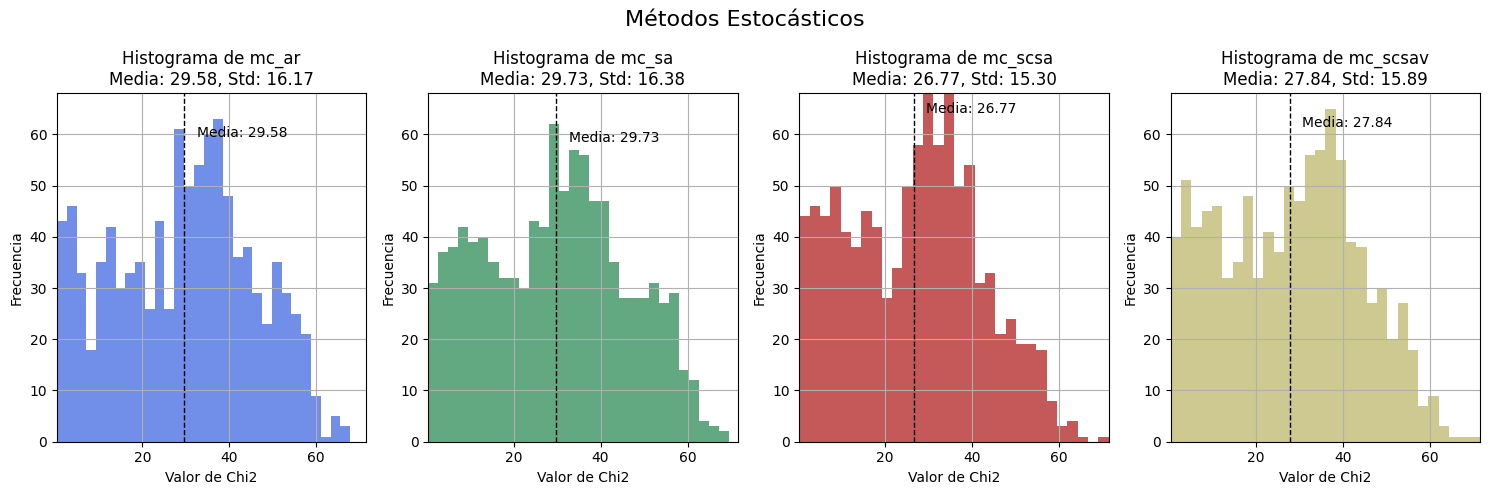

In [156]:
columns = df_chi.columns
colors = ['royalblue', 'seagreen', 'firebrick', 'darkkhaki', 'purple', 'orange', 'cyan']

x_range1, y_max1 = calculate_limits(columns[:4])

fig1, axs1 = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
fig1.suptitle('Métodos Estocásticos', fontsize=16)
axs1 = axs1.flatten()

for i, column in enumerate(columns[:4]):
    n, bins, patches = axs1[i].hist(df_chi[column], bins=30, alpha=0.75, color=colors[i])
    mean_val = df_chi[column].mean()
    axs1[i].axvline(mean_val, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = axs1[i].get_ylim()
    axs1[i].text(mean_val*1.1, max_ylim*0.9, f'Media: {mean_val:.2f}', color='black')
    std_val = df_chi[column].std()
    axs1[i].set_title(f'Histograma de {column}\nMedia: {mean_val:.2f}, Std: {std_val:.2f}')
    axs1[i].set_xlim(x_range1)
    axs1[i].set_ylim(0, y_max1)
    axs1[i].set_xlabel('Valor de Chi2')
    axs1[i].set_ylabel('Frecuencia')
    axs1[i].grid(True)

plt.tight_layout()
plt.show()


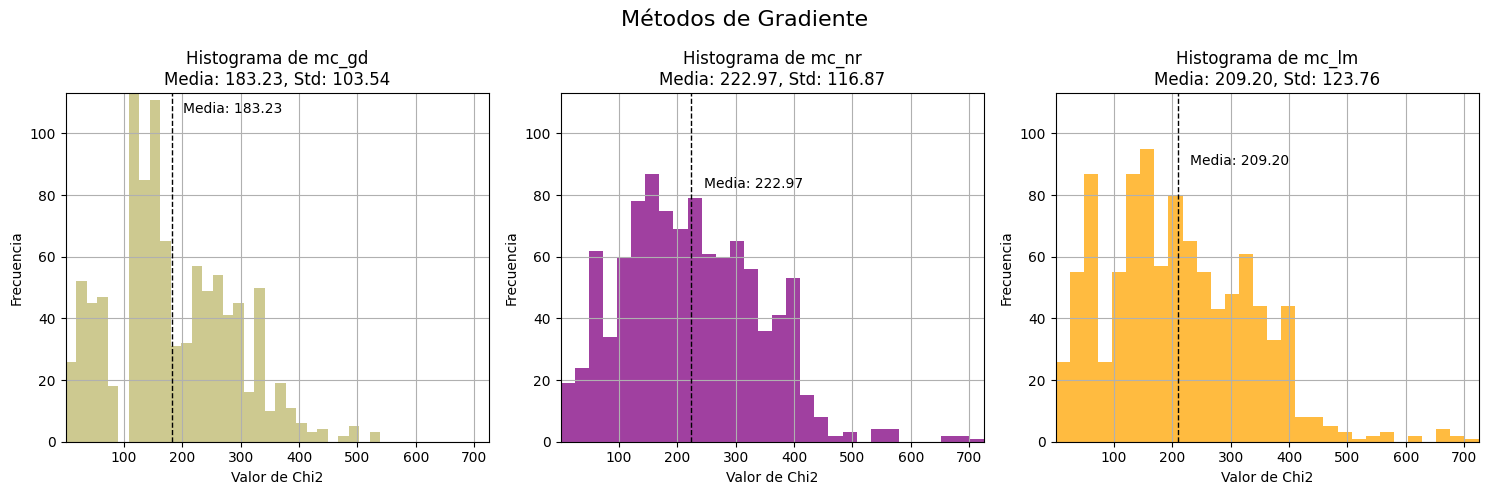

In [157]:
x_range2, y_max2 = calculate_limits(columns[4:])

fig2, axs2 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig2.suptitle('Métodos de Gradiente', fontsize=16)
axs2 = axs2.flatten()

for i, column in enumerate(columns[4:]):
    n, bins, patches = axs2[i].hist(df_chi[column], bins=30, alpha=0.75, color=colors[i + 3])
    mean_val = df_chi[column].mean()
    axs2[i].axvline(mean_val, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = axs2[i].get_ylim()
    axs2[i].text(mean_val*1.1, max_ylim*0.9, f'Media: {mean_val:.2f}', color='black')
    std_val = df_chi[column].std()
    axs2[i].set_title(f'Histograma de {column}\nMedia: {mean_val:.2f}, Std: {std_val:.2f}')
    axs2[i].set_xlim(x_range2)
    axs2[i].set_ylim(0, y_max2)
    axs2[i].set_xlabel('Valor de Chi2')
    axs2[i].set_ylabel('Frecuencia')
    axs2[i].grid(True)

plt.tight_layout()
plt.show()

#7. Discusiones y Conclusiones

- Los resultados indican que los métodos basados en gradiente son capaces de producir valores mínimos más bajos de $\chi^2$ en comparación con los métodos estocásticos, logrando así un ajuste más preciso. Sin embargo, su efectividad depende de la elección de un punto inicial adecuado para su convergencia al mínimo global, lo cual representa un desafío en un espacio de parámetros con múltiples mínimos locales. En estos casos, el rendimiento de los métodos de gradiente puede verse gravemente afectado.

- Además, la métrica NDMEV fue más alta para los métodos de gradiente, y los histogramas del menor valor de $\chi^2$ alcanzado en cada reinicio por estos métodos presentan una media y una desviación estándar mayores que las observadas en los histogramas para los métodos estocásticos. Esto se debe a los múltiples mínimos locales en los que los métodos de gradiente quedan atrapados.

- En contraste, los métodos éstocasticos obtuvieron mejores valores de NDMEV, aunque no lograron los valores más bajos de $\chi^2$. Esto se debe a la capacidad de estos métodos para escapar de mínimos locales y explorar el espacio de parámetros de manera más efectiva.

- El tiempo de ejecución normalizado varió significativamente entre los métodos. Siendo el método MCSCSAV el que requirio la mayor cantidad de tiempo de ejecución y el método de MCGD el más rápido. Lo métodos basados en gradiente, suelen ser de menor costo computacional cuando el punto de inicio es seleccionado  adecuadamente para su convergencia.

- EL método que más se acercó al valor verdadero del modelo con el cual se generaron los datos fue el método de MCSCSAV.

#8.  Animaciones

In [159]:
df_gd = leer_resultados('mc_gd')
df_sa = leer_resultados('mc_sa')
df_scsa = leer_resultados('mc_scsa')

In [160]:
indice_0 = df_gd['chi'].idxmin()
df_gd.loc[indice_0, 'i']
df_gd_n = df_gd.loc[df_gd['i'] == df_gd.loc[indice_0, 'i']]

In [161]:
indice_1 = df_sa['chi'].idxmin()
df_sa.loc[indice_1, 'i']
df_sa_n = df_sa.loc[df_sa['i'] == df_sa.loc[indice_1, 'i']]

In [162]:
indice_2 = df_scsa['chi'].idxmin()
df_scsa.loc[indice_2, 'i']
df_scsa_n = df_sa.loc[df_scsa['i'] == df_scsa.loc[indice_2, 'i']]

In [169]:
# Nombre del método
name = 'Método MC-GD'

# Crear figura con dos subplots (gráfico + texto)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
fig.suptitle(name, fontweight="bold")
camera = Camera(fig)

# Loop de animación
for i in range(0, len(df_gd_n['i'].values), 10):
    # --- Gráfico del ajuste ---
    ax1.clear()
    ax1.scatter(x_funcion1, datos_funcion1, alpha=0.5, color='cornflowerblue', label='Datos')
    ax1.plot(x_funcion1, y_funcion1, '--', color='green', label='Modelo real')
    ax1.plot(x_funcion1, funcion_1(x_funcion1, (df_gd_n['beta'].values[i], df_gd_n['gamma'].values[i])),
             '-', color='red', label='Ajuste iterativo')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.grid(True)
    ax1.legend(loc='upper right')

    # --- Texto con ecuación y parámetros ---
    ax2.clear()
    ax2.axis('off')

    beta = df_gd_n['beta'].values[i]
    gamma = df_gd_n['gamma'].values[i]

    # Recordemos: beta = [θ₁, θ₃, θ₅], gamma = [θ₂, θ₄]
    theta1, theta3, theta5 = beta
    theta2, theta4 = gamma

    eq_text = (
        r"$y(x) = \theta_1 \cos(\theta_2 x) + \theta_3 \sin(\theta_4 x) + \theta_5$" "\n\n"
        + fr"$\theta_1 = {theta1:.3f}$" "\n"
        + fr"$\theta_2 = {theta2:.3f}$" "\n"
        + fr"$\theta_3 = {theta3:.3f}$" "\n"
        + fr"$\theta_4 = {theta4:.3f}$" "\n"
        + fr"$\theta_5 = {theta5:.3f}$"
    )

    ax2.text(0.0, 0.5, eq_text, fontsize=12, va='center', ha='left', wrap=True)

    camera.snap()

# Crear animación
animation_gd = camera.animate(interval=150)
HTML(animation_gd.to_jshtml())

AttributeError: 'NoneType' object has no attribute 'canvas'

Error in callback <function _draw_all_if_interactive at 0x7f04fcebcd60> (for post_execute):


AttributeError: 'NoneType' object has no attribute 'canvas'

In [ ]:

matplotlib.use("agg")